In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import glob
import os
import random

In [2]:
import cv2 as cv

## Image data 

In [3]:
directories = glob.glob("./renders/*")
print(directories)

['./renders/epidural', './renders/multi', './renders/subdural', './renders/normal', './renders/subarachnoid', './renders/intraventricular', './renders/intraparenchymal']


In [4]:
nrows = len(directories)
ncols = 4

In [5]:
count_images = 0
for i, folder_path in enumerate(directories):
    for j, folder in enumerate(glob.glob(folder_path+"/*")):
        all_files = glob.glob(folder+'/*')
        subfolder_path = folder.split('/')[-2:]
        hemorrhage_type, window = subfolder_path
        print(f"folder -> {'/'.join(subfolder_path): >40}, {len(all_files):>7} files")
        count_images += len(all_files)
    print('------------------------------------------------')
print(f'total number of images: {count_images}')

folder ->                    epidural/brain_window,    1694 files
folder ->                 epidural/subdural_window,    1694 files
folder ->               epidural/brain_bone_window,    1694 files
folder ->             epidural/max_contrast_window,    1694 files
------------------------------------------------
folder ->                       multi/brain_window,   32074 files
folder ->                    multi/subdural_window,   32074 files
folder ->                  multi/brain_bone_window,   32074 files
folder ->                multi/max_contrast_window,   32074 files
------------------------------------------------
folder ->                    subdural/brain_window,   32200 files
folder ->                 subdural/subdural_window,   32200 files
folder ->               subdural/brain_bone_window,   32200 files
folder ->             subdural/max_contrast_window,   32200 files
------------------------------------------------
folder ->                      normal/brain_window,    6080 f

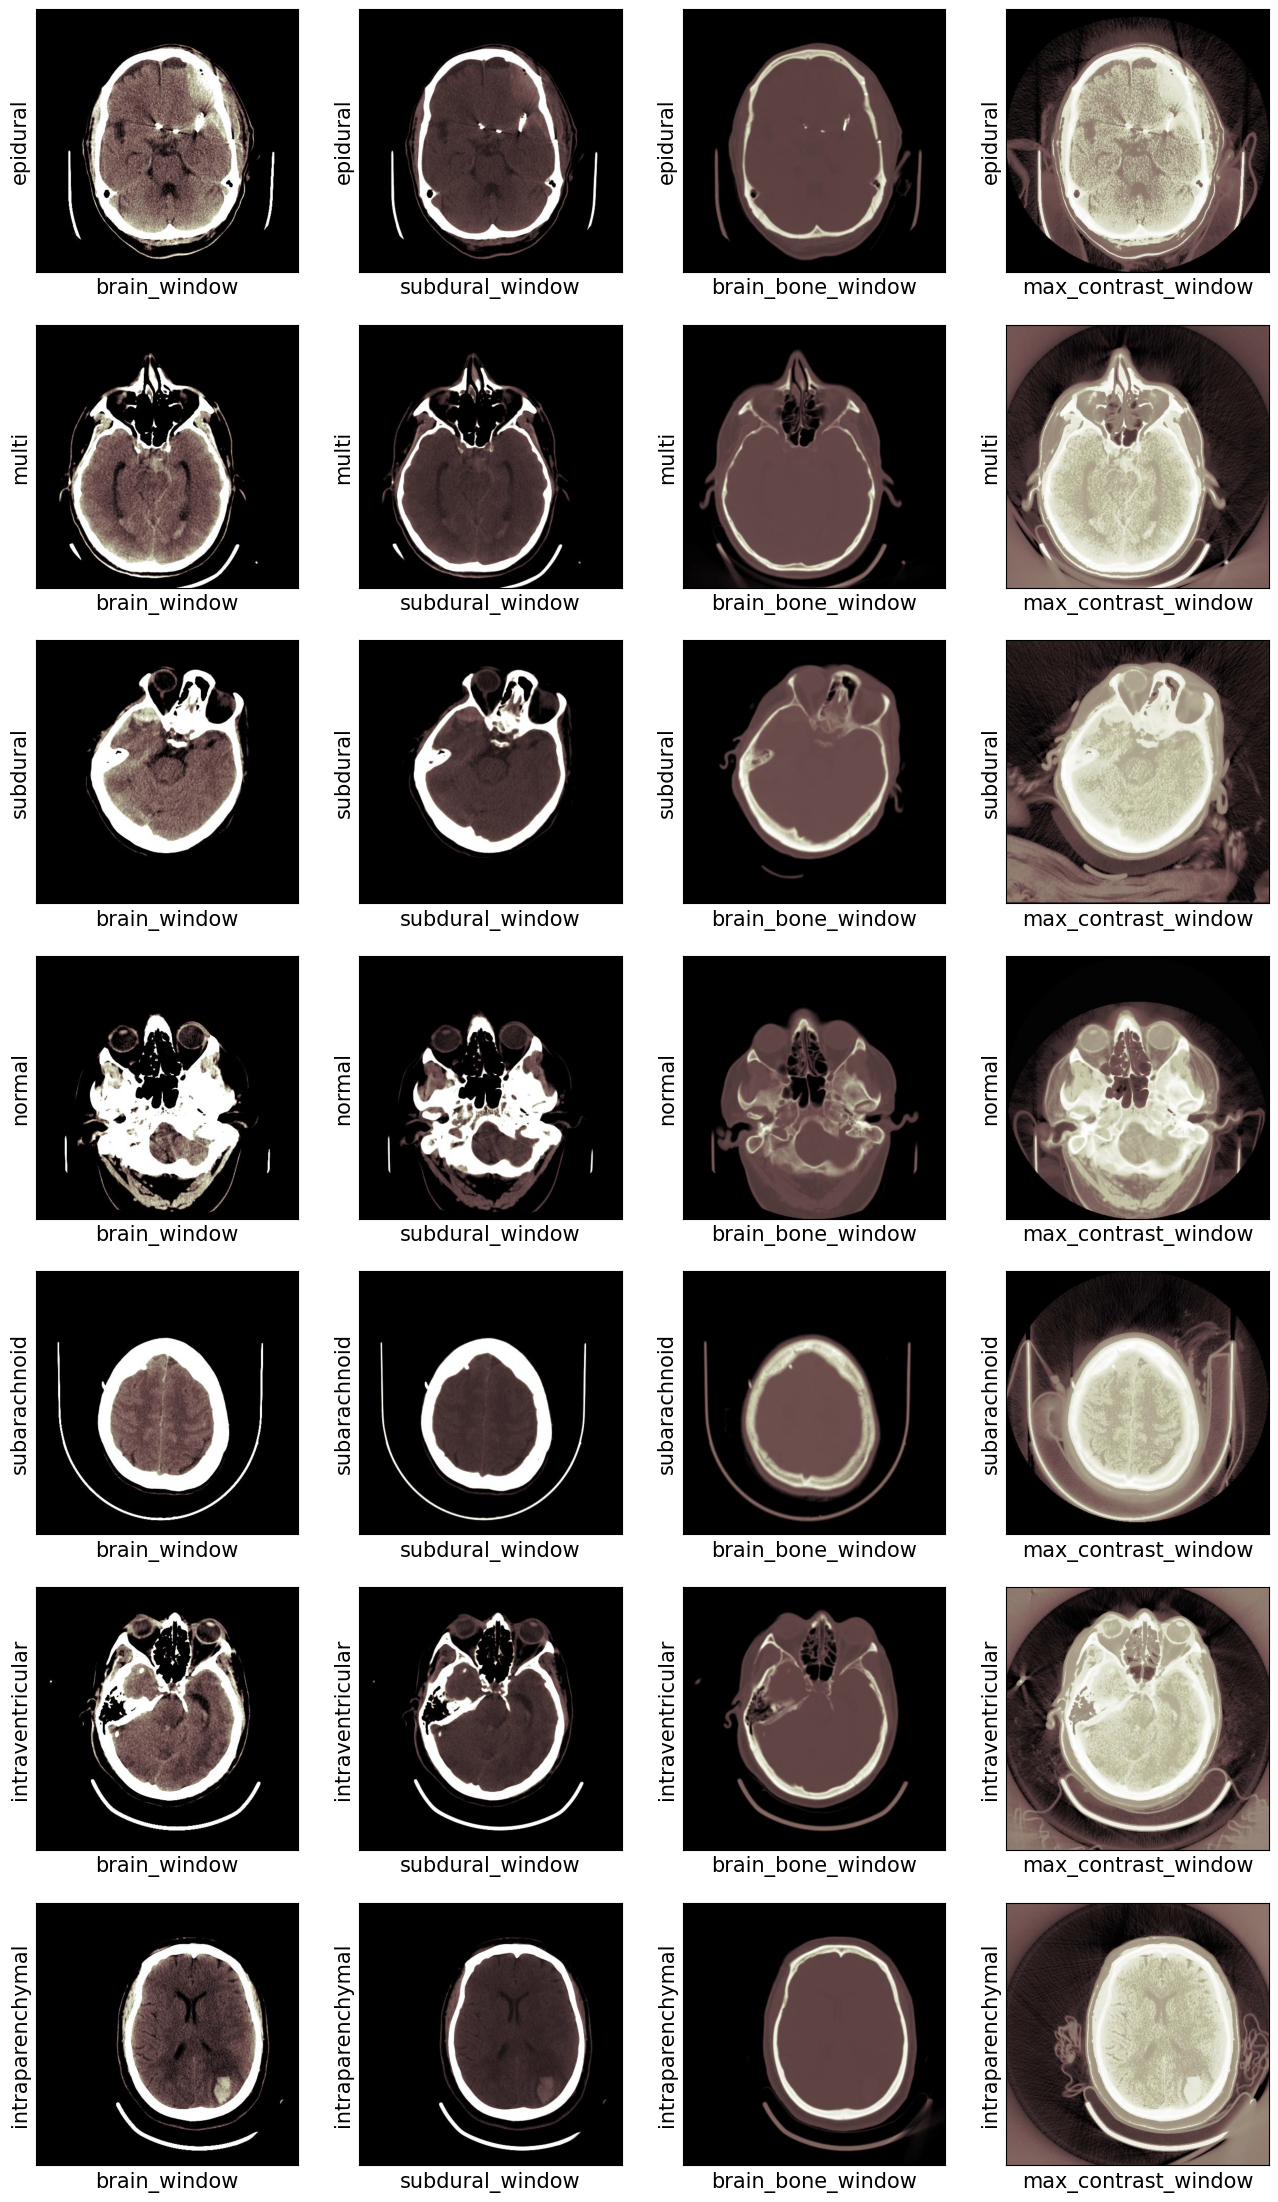

In [6]:
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
for i, folder_path in enumerate(directories):
    for j, folder in enumerate(glob.glob(folder_path+"/*")):
        all_files = glob.glob(folder+'/*')
        subfolder_path = folder.split('/')[-2:]
        hemorrhage_type, window = subfolder_path
#         print(f"folder -> {'/'.join(subfolder_path): >40}, {len(all_files):>7} files")
        if j==0:
            img_path = random.choice(all_files)
        img_name = '/'.join(img_path.split('/')[:-2]) + '/' + window + '/' + img_path.split('/')[-1]
        ax[i,j].imshow(cv.imread(img_name), cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if True:
            ax[i,j].set_ylabel(hemorrhage_type, fontsize=15)
        if True:
            ax[i,j].set_xlabel(window, fontsize=15)

In [25]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define base dataset path
BASE_PATH = "./renders/"

# List of hemorrhage types (directories)
HEMORRHAGE_TYPES = ["epidural", "intraparenchymal", "intraventricular", 
                    "multi", "normal", "subarachnoid", "subdural"]

# Window types
IMAGE_TYPES = ["brain_window", "subdural_window", "brain_bone_window", "max_contrast_window"]

# Load labels
df_labels = pd.read_csv("./labels/hemorrhage_labels.csv")  # Ensure this CSV contains correct image IDs and labels
df_labels.set_index("Image", inplace=True)  # Set image ID as index

In [26]:
num_0 = df_labels[df_labels["any"] == 0].shape[0]
num_1 = df_labels[df_labels["any"] == 1].shape[0]
print(f"Number of negative examples: {num_0}")
print(f"Number of positive examples: {num_1}")

Number of negative examples: 644870
Number of positive examples: 107933


In [27]:


# Define dataset path
IMAGE_TYPE = "subdural_window"  # Choose one image type


# Function to load images for selected image type
def load_images(image_size=(128, 128)):
    X, y = [], []
    total_images = 0
    missing_images = 0

    print(f"Starting image loading for type: {IMAGE_TYPE}...")

    for hemorrhage_type in HEMORRHAGE_TYPES:
        folder_path = os.path.join(BASE_PATH, hemorrhage_type, IMAGE_TYPE)
        if not os.path.exists(folder_path):
            print(f"Skipping missing folder: {folder_path}")
            continue

        print(f"Processing {hemorrhage_type} images from {folder_path}...")
        count = 0
        
        for image_id in df_labels.index:
            image_path = os.path.join(folder_path, image_id + ".jpg")  # Adjust extension if needed
            if os.path.exists(image_path):
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
                img = cv2.resize(img, image_size)  # Resize
                X.append(img.flatten())  # Flatten image
                y.append(df_labels.loc[image_id, "any"])  # Use 'any' column for hemorrhage classification
                # print(f'image id: {image_id}, label: {df_labels.loc[image_id, "any"]}')
                count += 1
            else:
                missing_images += 1

        print(f"Loaded {count} images from {hemorrhage_type}.")
        total_images += count

    print(f"Finished image loading: {total_images} images loaded, {missing_images} missing.")
    return np.array(X), np.array(y)

# Load dataset
X, y = load_images()
if len(X) == 0:
    print("No images found. Check dataset paths and image extensions.")
    raise ValueError("No images found.")



Starting image loading for type: subdural_window...
Processing epidural images from ./renders/epidural/subdural_window...
Loaded 1694 images from epidural.
Processing intraparenchymal images from ./renders/intraparenchymal/subdural_window...
Loaded 15664 images from intraparenchymal.
Processing intraventricular images from ./renders/intraventricular/subdural_window...
Loaded 9878 images from intraventricular.
Processing multi images from ./renders/multi/subdural_window...
Loaded 32074 images from multi.
Processing normal images from ./renders/normal/subdural_window...
Loaded 8278 images from normal.
Processing subarachnoid images from ./renders/subarachnoid/subdural_window...
Loaded 16423 images from subarachnoid.
Processing subdural images from ./renders/subdural/subdural_window...
Loaded 32200 images from subdural.
Finished image loading: 116211 images loaded, 5153410 missing.


In [28]:
# Shuffle dataset
print("Shuffling dataset...")
indices = np.arange(len(X))
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Balance the dataset
print("Balancing dataset with equal positive and negative samples...")

# Find indices for positive and negative samples
pos_indices = np.where(y == 1)[0]
neg_indices = np.where(y == 0)[0]

# Get the smaller count
min_samples = min(len(pos_indices), len(neg_indices))
print(f"Balancing to {min_samples} samples per class.")

# Sample equal number of positives and negatives
selected_pos_indices = np.random.choice(pos_indices, min_samples, replace=False)
selected_neg_indices = np.random.choice(neg_indices, min_samples, replace=False)

# Combine selected indices
final_indices = np.concatenate((selected_pos_indices, selected_neg_indices))
np.random.shuffle(final_indices)

# Create balanced dataset
X_balanced, y_balanced = X[final_indices], y[final_indices]
print(f"Final dataset size: {len(X_balanced)} (Positive: {min_samples}, Negative: {min_samples})")


Shuffling dataset...
Balancing dataset with equal positive and negative samples...
Balancing to 8278 samples per class.
Final dataset size: 16556 (Positive: 8278, Negative: 8278)


In [29]:
# Split dataset into train and test sets
print("Splitting dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Splitting dataset into training and testing sets...
Training samples: 13244, Testing samples: 3312


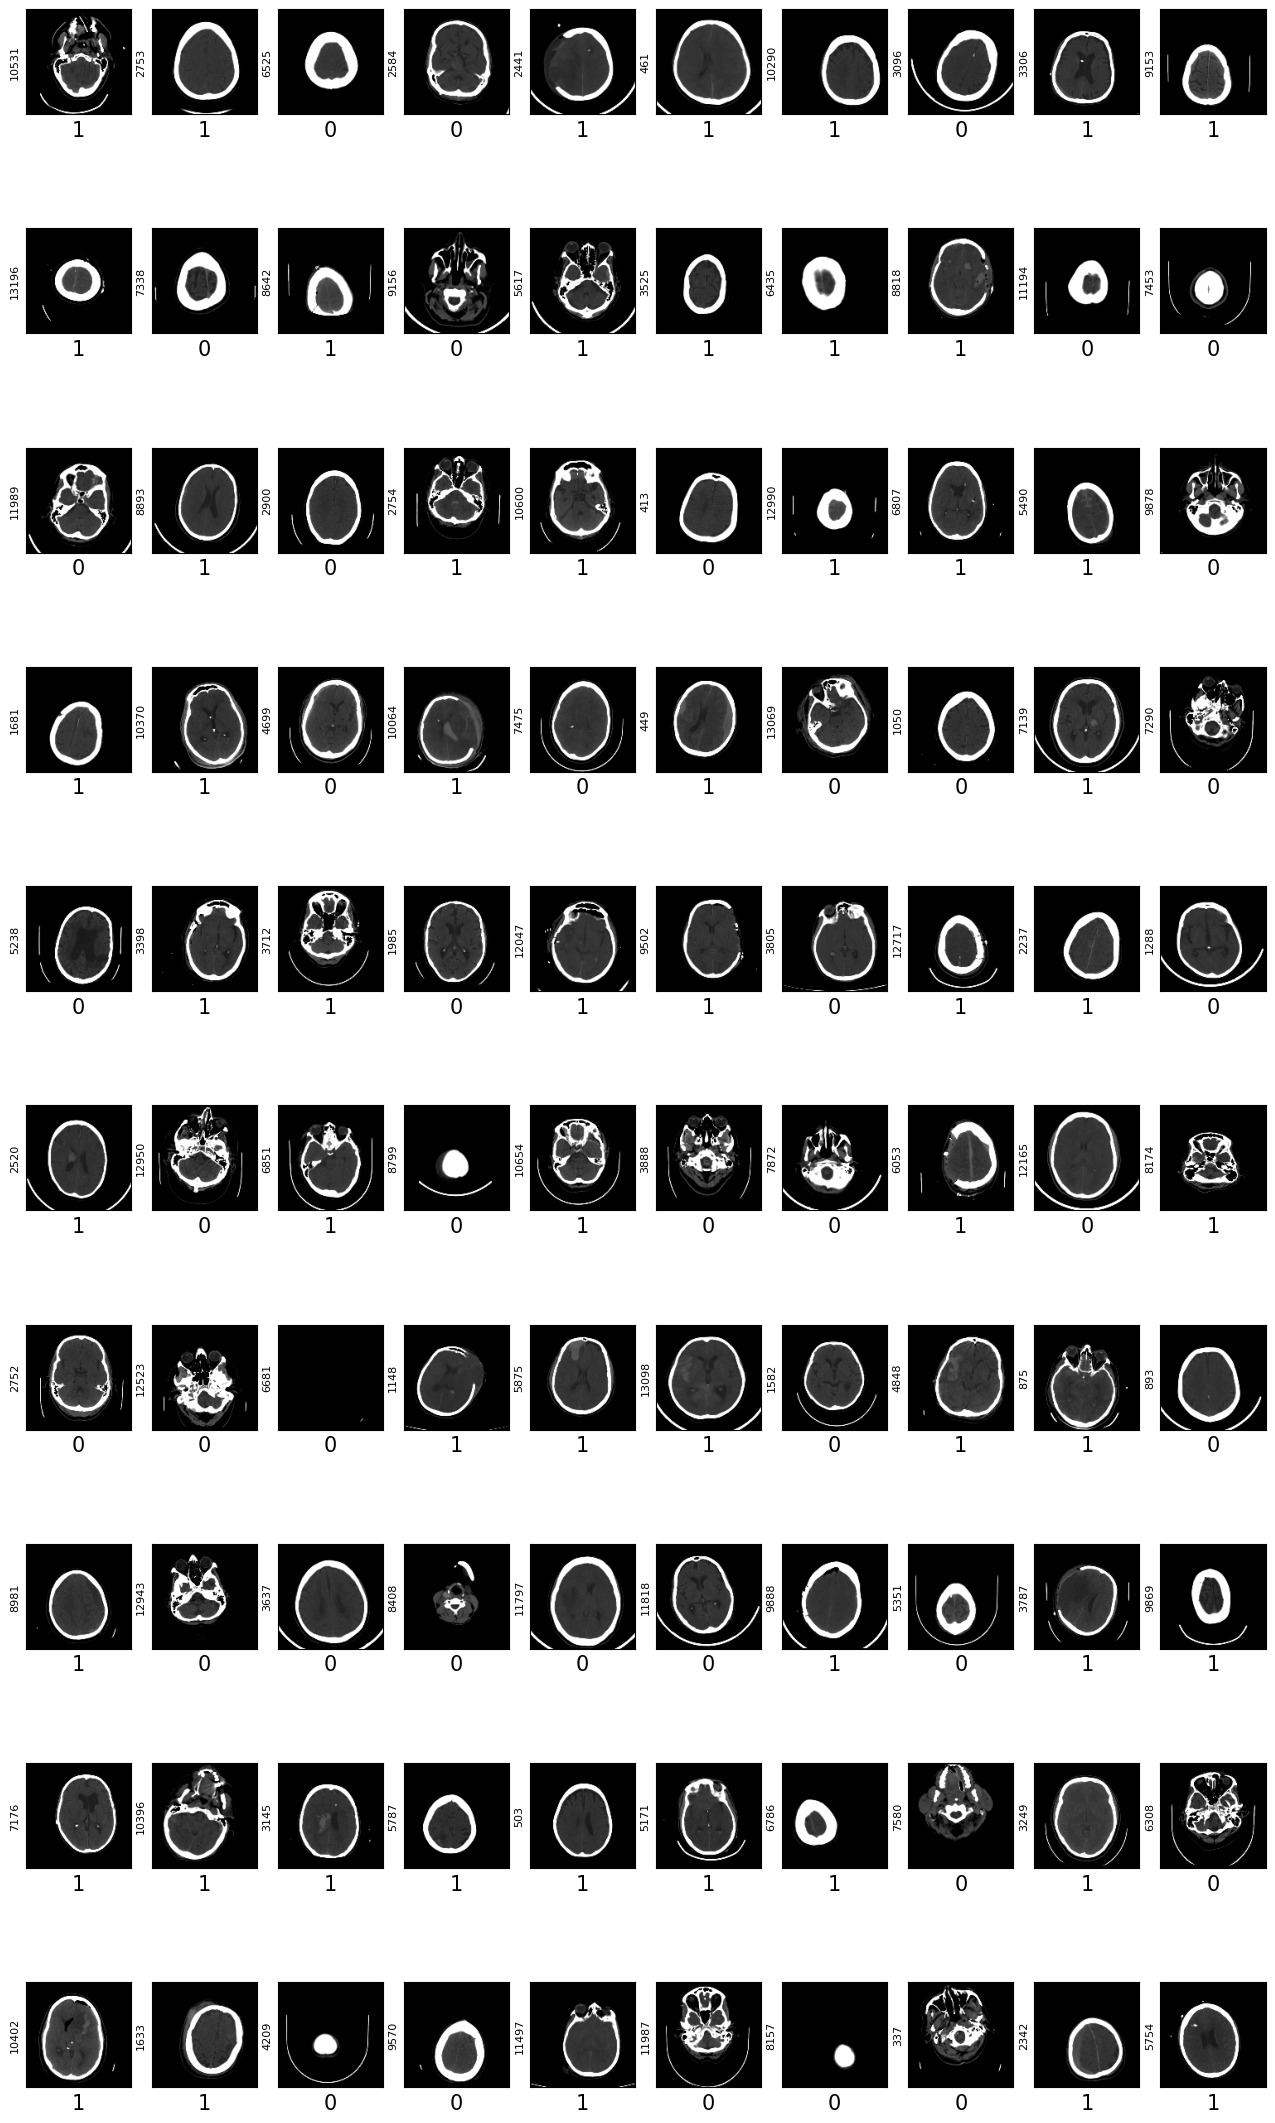

In [30]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(ncols*4, nrows*4))
for i in range(10):
    for j in range(10):
        rnd = np.random.randint(0, len(X_train))
        ax[i,j].imshow(X_train[rnd].reshape(128, 128), cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])  
        ax[i,j].set_xlabel(y_train[rnd], fontsize=15)
        ax[i,j].set_ylabel(rnd, fontsize=8)



In [31]:


# Train QDA model
print("Training QDA model...")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
print("QDA model training completed.")

# Evaluate model
print("Evaluating model on test set...")
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"QDA Classification Accuracy using {IMAGE_TYPE}: {accuracy:.4f}")


Training QDA model...


/opt/anaconda3/envs/minoo_env/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/minoo_env/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


QDA model training completed.
Evaluating model on test set...
QDA Classification Accuracy using subdural_window: 0.5036


### SVM with Kernel Method for Image Classification

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np


print("Splitting into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

print("Normalizing the dataset...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training SVM with RBF kernel...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  
svm_model.fit(X_train_scaled, y_train)

print("Evaluating the model...")
y_pred = svm_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Splitting into training and testing sets...
Normalizing the dataset...
Training SVM with RBF kernel...
Evaluating the model...
Accuracy: 0.7397342995169082
Confusion Matrix:
 [[1041  615]
 [ 247 1409]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.63      0.71      1656
           1       0.70      0.85      0.77      1656

    accuracy                           0.74      3312
   macro avg       0.75      0.74      0.74      3312
weighted avg       0.75      0.74      0.74      3312



### Classifying into 7 classes:

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==== SETUP ====

BASE_PATH = "./renders/"
IMAGE_TYPE = "subdural_window"
IMAGE_SIZE = (128, 128)
HEMORRHAGE_TYPES = ["epidural", "intraparenchymal", "intraventricular", 
                    "multi", "normal", "subarachnoid", "subdural"]

# Load label CSV
df_labels = pd.read_csv("./labels/hemorrhage_labels.csv")
df_labels.set_index("Image", inplace=True)

# ==== LOAD DATASET WITH MULTI-CLASS LABELS ====

def load_images_multiclass(image_size=(128, 128)):
    X = []
    y = []
    total_images, missing_images = 0, 0

    print(f"Loading dataset with 7-class labels using window type: {IMAGE_TYPE}...")


    for label in HEMORRHAGE_TYPES:
        folder_path = os.path.join(BASE_PATH, label, IMAGE_TYPE)
        if not os.path.exists(folder_path):
            print(f"Skipping missing folder: {folder_path}")
            continue

        count = 0
        for image_id in df_labels.index:
            image_path = os.path.join(folder_path, image_id + ".jpg")
            if os.path.exists(image_path):
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, image_size)
                X.append(img.flatten())
                y.append(label)  # Use folder name as class label
                count += 1
            else:
                missing_images += 1

        print(f"Loaded {count} images from {label}.")
        total_images += count

    print(f"Total loaded: {total_images}, Missing: {missing_images}")
    return np.array(X), np.array(y)

X, y = load_images_multiclass()

if len(X) == 0:
    raise ValueError("No images loaded. Please check paths.")

# ==== LABEL ENCODING FOR MULTICLASS ====

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:", list(le.classes_))

# ==== SPLIT AND NORMALIZE ====

print("Splitting and normalizing data...")
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# from sklearn.decomposition import PCA

# print("Applying PCA for dimensionality reduction...")
# pca = PCA(n_components=0.50, svd_solver='full')
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# print(f"Reduced dimensions: {X_train_pca.shape[1]}")

print("Training SVM with RBF kernel (with max_iter)...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', max_iter=100)
svm_model.fit(X_train_scaled, y_train)

# Evaluate
print("Evaluating...")
y_pred = svm_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Loading dataset with 7-class labels using window type: subdural_window...
Loaded 1694 images from epidural.
Loaded 15664 images from intraparenchymal.
Loaded 9878 images from intraventricular.
Loaded 32074 images from multi.
Loaded 8278 images from normal.
Loaded 16423 images from subarachnoid.
Loaded 32200 images from subdural.
Total loaded: 116211, Missing: 5153410
Classes: [np.str_('epidural'), np.str_('intraparenchymal'), np.str_('intraventricular'), np.str_('multi'), np.str_('normal'), np.str_('subarachnoid'), np.str_('subdural')]
Splitting and normalizing data...
Training SVM with RBF kernel (with max_iter)...


/opt/anaconda3/envs/minoo_env/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Evaluating...
Accuracy: 0.12373617863442757
Confusion Matrix:
 [[ 110   89    3   21    9   58   49]
 [1065  892   46  180   54  443  453]
 [ 710  597   14  113   58  223  261]
 [1838 1788   77  420  121  993 1178]
 [ 892  411   18   51   65   96  122]
 [1240 1012   40  147   45  419  382]
 [2337 1819   47  290  123  868  956]]
Classification Report:
                   precision    recall  f1-score   support

        epidural       0.01      0.32      0.03       339
intraparenchymal       0.13      0.28      0.18      3133
intraventricular       0.06      0.01      0.01      1976
           multi       0.34      0.07      0.11      6415
          normal       0.14      0.04      0.06      1655
    subarachnoid       0.14      0.13      0.13      3285
        subdural       0.28      0.15      0.19      6440

        accuracy                           0.12     23243
       macro avg       0.16      0.14      0.10     23243
    weighted avg       0.22      0.12      0.13     23243



## Simple CNN for classification

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ==== SETUP ====

# Define base path
BASE_PATH = "./renders/"

# Image window types used as input channels
IMAGE_TYPES = ["brain_window", "subdural_window", "brain_bone_window", "max_contrast_window"]

# Hemorrhage type folders (used to locate images)
HEMORRHAGE_TYPES = ["epidural", "intraparenchymal", "intraventricular", 
                    "multi", "normal", "subarachnoid", "subdural"]

# Load labels CSV
df_labels = pd.read_csv("./labels/hemorrhage_labels.csv")
df_labels.set_index("Image", inplace=True)  # Ensure image ID is index
IMAGE_SIZE = (128, 128)

# ==== LOAD 4-CHANNEL IMAGE DATA ====

def load_multiview_images(image_size=(128, 128)):
    X, y = [], []
    total_loaded, missing = 0, 0

    print("Loading all 4 window types for each sample...")

    for hemorrhage_type in HEMORRHAGE_TYPES:
        print(f"Checking folder: {hemorrhage_type}")
        for image_id in df_labels.index:
            image_views = []

            for view_type in IMAGE_TYPES:
                image_path = os.path.join(BASE_PATH, hemorrhage_type, view_type, image_id + ".jpg")
                if os.path.exists(image_path):
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, image_size)
                    image_views.append(img)
                else:
                    break  # Skip this sample if any view is missing

            if len(image_views) == 4:
                stacked = np.stack(image_views, axis=-1)  # Shape: (H, W, 4)
                X.append(stacked)
                y.append(df_labels.loc[image_id, "any"])
                total_loaded += 1
            else:
                missing += 1

    print(f"Finished loading. Loaded: {total_loaded}, Skipped: {missing}")
    return np.array(X), np.array(y)

# ==== LOAD & BALANCE DATASET ====

X, y = load_multiview_images(image_size=IMAGE_SIZE)

Loading all 4 window types for each sample...
Checking folder: epidural
Checking folder: intraparenchymal
Checking folder: intraventricular
Checking folder: multi
Checking folder: normal
Checking folder: subarachnoid
Checking folder: subdural
Finished loading. Loaded: 114013, Skipped: 5155608


In [ ]:


print("Shuffling and balancing dataset...")
indices = np.arange(len(X))
np.random.shuffle(indices)
X, y = X[indices], y[indices]

pos_idx = np.where(y == 1)[0]
neg_idx = np.where(y == 0)[0]
min_count = min(len(pos_idx), len(neg_idx))

sel_pos = np.random.choice(pos_idx, min_count, replace=False)
sel_neg = np.random.choice(neg_idx, min_count, replace=False)
final_idx = np.concatenate((sel_pos, sel_neg))
np.random.shuffle(final_idx)

X_bal, y_bal = X[final_idx], y[final_idx]
print(f"Balanced dataset size: {len(X_bal)}")

# ==== TRAIN/TEST SPLIT ====

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# ==== BUILD CNN ====

print("Building CNN model...")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ==== TRAIN MODEL ====

print("Training model...")
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# ==== EVALUATE MODEL ====

print("Evaluating model...")
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")
